## Introduction

This notebook trains and evaluates the machine learning models for predicting
delivery duration. After preprocessing and feature engineering, we now focus on:

1. establishing a reliable LightGBM baseline using leakage-safe OOF validation,
2. training specialized models on different feature groups,
3. combining their predictions using a simple and robust stacking approach,
4. evaluating model performance and analyzing contribution of each component.

The goal is to build a stable, high-performing model that generalizes well to
unseen data while avoiding target leakage.


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.optimize import nnls
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# Determine project root directory
project_root = next(
    (p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / "src").exists()),
    Path.cwd()
)
sys.path.insert(0, str(project_root))

# Import functions from src/modeling.py
from src.modeling import run_lgb_oof, run_linear_stacking


## 1. Setup and Data Loading

We load the feature-engineered training, validation, and test datasets stored in
Parquet format. To reduce memory usage and speed up training, we downcast
selected integer and float columns.

These datasets contain all cleaned and engineered features from previous
notebooks and serve as the starting point for model training.


In [2]:
train_df = pd.read_parquet(project_root / "data" / "processed" / "train_features.parquet",  engine="pyarrow")
valid_df = pd.read_parquet(project_root / "data" / "processed" / "valid_features.parquet",  engine="pyarrow")
test_df = pd.read_parquet(project_root / "data" / "processed" / "test_features.parquet",  engine="pyarrow")

# Columns to convert to int32
int64_to_int32 = [
    "order_subtotal_bucket",
    "order_total_items_bucket",
    "order_distinct_items_bucket",
    "store_order_volume"
]

# Columns to convert to float32
float64_to_float32 = [
    "time_hour_sin", "time_hour_cos",
    "time_dow_sin", "time_dow_cos",
    "order_avg_item_price",
    "order_percent_distinct_items",
    "load_roll_outstanding_mean",
    "load_roll_onshift_mean",
    "load_roll_busy_mean",
    "load_roll_busy_ratio_mean",
    "load_roll_demand_supply_mean",
    "load_roll_outstanding_std",
    "load_roll_busy_std",
    "load_recent_order_count",
    "load_demand_momentum",
    "load_supply_momentum",
    "load_busy_momentum",
    "load_utilization_volatility",
    "load_pressure_index",
    "total_onshift_dashers_lag_5min",
    "total_onshift_dashers_lag_15min",
    "total_onshift_dashers_lag_30min",
    "total_busy_dashers_lag_5min",
    "total_busy_dashers_lag_15min",
    "total_busy_dashers_lag_30min",
    "total_outstanding_orders_lag_5min",
    "total_outstanding_orders_lag_15min",
    "total_outstanding_orders_lag_30min",
    "load_busy_ratio_lag_5min",
    "load_busy_ratio_lag_15min",
    "load_busy_ratio_lag_30min",
    "load_demand_supply_ratio_lag_5min",
    "load_demand_supply_ratio_lag_15min",
    "load_demand_supply_ratio_lag_30min",
    "total_onshift_dashers_roll10_std",
    "total_busy_dashers_roll10_std",
    "total_outstanding_orders_roll10_std",
    "load_busy_ratio_roll10_std",
    "load_demand_supply_ratio_roll10_std",
    "demand_spike_15m",
    "supply_drop_15m",
    "busy_growth_15m",
    "burst_index",
    "store_primary_category_encoded",
    "store_id_encoded",
    "market_id_encoded",
    "order_protocol_encoded",
    "interaction__order_subtotal__x__store_id_encoded",
    "interaction__order_total_items__x__load_busy_ratio",
    "interaction__time_hour_sin__x__load_demand_supply_ratio",
    "interaction__store_id_encoded__x__order_avg_item_price"
]

# Convert data types to reduce memory usage
for df in [train_df, valid_df, test_df]:
    df[int64_to_int32] = df[int64_to_int32].astype("int32")
    df[float64_to_float32] = df[float64_to_float32].astype("float32")


In [3]:
print("Train:", train_df.shape, "Valid:", valid_df.shape, "Test:", test_df.shape)

Train: (137399, 92) Valid: (29443, 92) Test: (29443, 92)


## 2. A Trusted Baseline

We start by training a LightGBM model using the combined training and validation
splits. Unlike earlier benchmarks that treated validation as a strictly separate
holdout, here we merge them to give the model access to more data during OOF
training. 

This approach increases the amount of variation the model can learn from while
still preserving leakage-free evaluation through out-of-fold predictions. Each
fold acts as its own validation slice, so the model never sees the rows it is
scored on, even though we train on the full combined dataset.

The resulting baseline represents the strongest single-model signal we can
produce before exploring horizon models or stacking, and it serves as the
primary reference point for all later improvements.


OOF MAE: 569.70
OOF RMSE: 759.28

Baseline Results: 
OOF MAE:  569.70
OOF RMSE: 759.28
------------------------------
TEST MAE: 602.18
TEST RMSE: 806.10


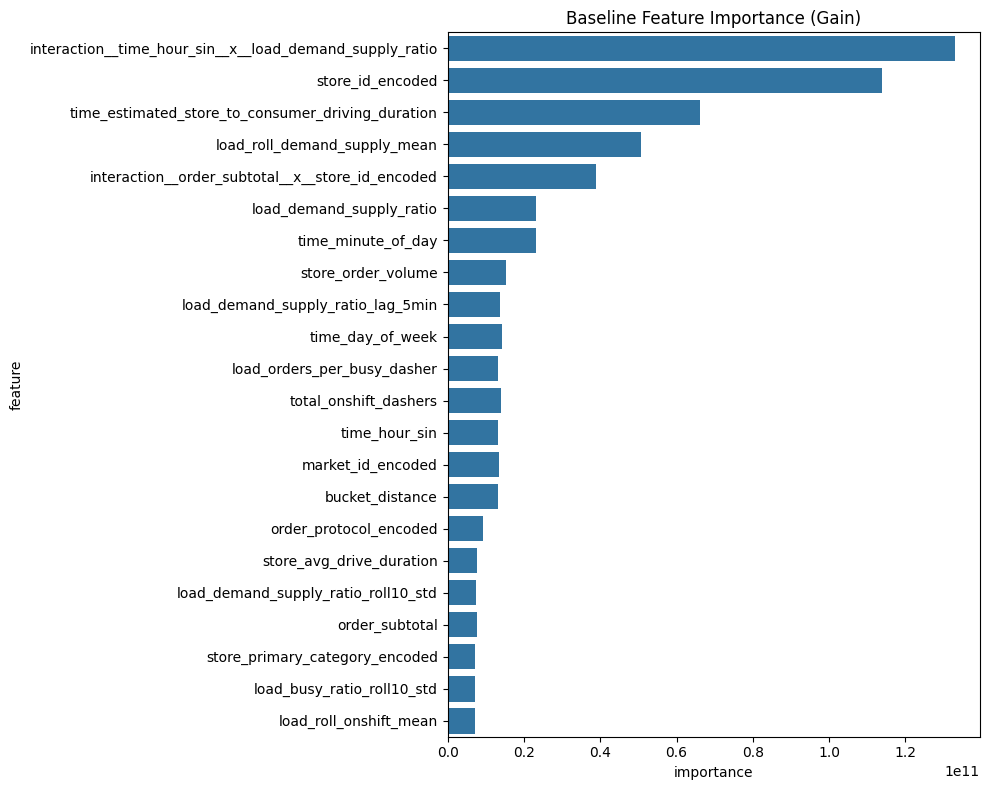

In [4]:
# Establish Baseline Model using LightGBM with 5-Fold Cross Validation

# Combine Train and Valid for 5-Fold Cross Validation
full_train_df = pd.concat([train_df, valid_df]).reset_index(drop=True)
TARGET = "target_delivery_seconds"

# 2. Define Features
features = [
    col for col in full_train_df.columns
    if col not in [TARGET, "created_at", "actual_delivery_time"]
    and full_train_df[col].dtype not in ['object', '<M8[ns]'] # Exclude strings/dates
]

# Run OOF Model
baseline_oof_preds, baseline_test_preds, baseline_models = run_lgb_oof(
    full_train_df, 
    test_df, 
    features, 
    TARGET, 
    n_folds=5, 
    verbose=True
)

# Display Metrics
y_true = np.asarray(full_train_df[TARGET].values).ravel()
y_test = np.asarray(test_df[TARGET].values).ravel()

print("\n" + "="*30)
print("Baseline Results: ")   
print("="*30)
print(f"OOF MAE:  {mean_absolute_error(y_true, baseline_oof_preds):.2f}")
print(f"OOF RMSE: {np.sqrt(mean_squared_error(y_true, baseline_oof_preds)):.2f}")
print("-" * 30)
print(f"TEST MAE: {mean_absolute_error(y_test, baseline_test_preds):.2f}")
print(f"TEST RMSE: {np.sqrt(mean_squared_error(y_test, baseline_test_preds)):.2f}")
# Visualize Feature Importance (Averaged across folds)
feature_importance = pd.DataFrame()
for i, model in enumerate(baseline_models):
    fold_imp = pd.DataFrame({
        "feature": features,
        "importance": model.feature_importance(importance_type="gain"),
        "fold": i + 1
    })
    feature_importance = pd.concat([feature_importance, fold_imp])

# Plot Top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.sort_values("importance", ascending=False).head(100), # Top 20 aggregated
    x="importance", 
    y="feature", 
    errorbar=None
)
plt.title("Baseline Feature Importance (Gain)")
plt.tight_layout()
plt.show()

### Baseline Review

#### OOF Performance Improvement

The updated OOF LightGBM baseline shows a meaningful improvement over the
original benchmark from the Feature Engineering notebook. MAE decreased from
583.25 to 569.70, indicating stronger generalization and better error
stability.

This gain comes from training the model on the combined training + validation
data while still using out-of-fold predictions to avoid leakage. By exposing
the model to more examples, especially across diverse stores, markets, and
operational conditions, it learns a broader range of patterns without
overfitting to any particular time slice. This suggests that performance would
continue to improve with additional raw data sources such as distances,
real-time traffic indicators, or longer historical/seasonal trends.

#### Feature Importance

LightGBM’s gain-based feature importance highlights the signals that contribute
most to prediction accuracy. The strongest drivers include:

- demand/supply ratios,
- estimated durations,
- store-encoded effects,
- time-of-day structure,
- lagged telemetry features.

These insights help identify which operational horizons carry the most signal
and guide where more targeted modeling (e.g., short-horizon or long-horizon
submodels) is likely to be useful.


## 3. Horizon-Based Feature Groups

To explore how different types of signals contribute to prediction quality, we
split the full feature set into three groups:

- **Short Horizon (SH):**  
  Real-time and near-real-time market signals  
  (telemetry, lagged telemetry, short-term volatility, spikes, and velocity)

- **Medium Horizon (MH):**  
  Order-level context and medium-timescale marketplace load  
  (rolling averages, robust buckets, momentum, price and item characteristics)

- **Long Horizon (LH):**  
  Stable or structural attributes  
  (store encodings, market encodings, protocol, month, static order features)

Each horizon captures a different frequency or timescale of operational behavior.
Training them independently allows us to understand which components generalize
best and whether certain signals might complement each other.


In [5]:
# Short Horizon (SH) - Real-time Market Dynamics
FEATURES_SH = [
    # Raw telemetry
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "load_busy_ratio",
    "load_demand_supply_ratio",

    # Velocity Features
    "market_velocity_orders",
    "market_velocity_busy",

    # Lagged telemetry (5m, 15m, 30m)
    "total_onshift_dashers_lag_5min",
    "total_onshift_dashers_lag_15min",
    "total_onshift_dashers_lag_30min",
    "total_busy_dashers_lag_5min",
    "total_busy_dashers_lag_15min",
    "total_busy_dashers_lag_30min",
    "total_outstanding_orders_lag_5min",
    "total_outstanding_orders_lag_15min",
    "total_outstanding_orders_lag_30min",
    "load_busy_ratio_lag_5min",
    "load_busy_ratio_lag_15min",
    "load_busy_ratio_lag_30min",
    "load_demand_supply_ratio_lag_5min",
    "load_demand_supply_ratio_lag_15min",
    "load_demand_supply_ratio_lag_30min",

    # Short-horizon rolling volatility
    "total_onshift_dashers_roll10_std",
    "total_busy_dashers_roll10_std",
    "total_outstanding_orders_roll10_std",
    "load_busy_ratio_roll10_std",
    "load_demand_supply_ratio_roll10_std",

    # Spike features
    "demand_spike_15m",
    "supply_drop_15m",
    "busy_growth_15m",
    "burst_index",

    # Time-of-day context (helps short horizon noise)
    "time_hour_sin",
    "time_hour_cos",
    "time_minute_of_day",
]

# Medium Horizon (MH) - Session & Order Context
FEATURES_MH = [    

    # Marketplace rolling behavior (medium timescale)
    "load_roll_outstanding_mean",
    "load_roll_onshift_mean",
    "load_roll_busy_mean",
    "load_roll_busy_ratio_mean",
    "load_roll_demand_supply_mean",
    "load_roll_outstanding_std",
    "load_roll_busy_std",

    # Robust Buckets
    "bucket_distance",
    "bucket_dashers",

    # Order metadata
    "order_avg_item_price",
    "order_percent_distinct_items",
    "order_item_price_range",
    "order_high_value",

    # Estimate components
    "time_estimated_order_place_duration",
    "time_estimated_store_to_consumer_driving_duration",

    # Time-of-week effects
    "time_day_of_week",
    "time_is_rush_hour",
    "time_is_weekend",
    "time_bucket_48",

    # Momentum signals
    "load_demand_momentum",
    "load_supply_momentum",
    "load_busy_momentum",
    "load_recent_order_count",

    # Interactions
    "interaction__order_subtotal__x__store_id_encoded",
    "interaction__order_total_items__x__load_busy_ratio",
    "interaction__time_hour_sin__x__load_demand_supply_ratio",
    "interaction__store_id_encoded__x__order_avg_item_price",
]

# Long Horizon (LH) - Structural & Static
FEATURES_LH = [
    # OOF Encodings (Replaces Raw IDs)
    "store_id_encoded",
    "market_id_encoded",
    "store_primary_category_encoded",
    "order_protocol_encoded",

    # Stable temporal structure
    "time_month",
    "time_dow_sin",
    "time_dow_cos",

    # Order-level static attributes
    "order_subtotal",
    "order_total_items",
    "order_num_distinct_items",
    "order_subtotal_bucket",
    "order_total_items_bucket",
    "order_distinct_items_bucket",
]

### Training Horizon Models

Each horizon model is trained using the same OOF LightGBM routine as the
baseline but with its own feature subset. The resulting OOF predictions act as
meta-features for stacking.

Comparing these models helps reveal:
- whether real-time signals (SH) outperform structural ones (LH),
- whether medium-scale order and marketplace signals (MH) add explanatory power,
- how each horizon performs relative to the full-feature baseline.


In [6]:
# Establish Y for Full Train and Test
y_train = full_train_df[TARGET]
y_test = test_df[TARGET]

# Define Horizon Groups
horizons = {
    "SH": FEATURES_SH,
    "MH": FEATURES_MH,
    "LH": FEATURES_LH
}

# Storage for Stacking
oof_preds_dict = {}
test_preds_dict = {}
horizon_models = {}

# Run Loop
for name, feature_list in horizons.items():
    print(f"\n{'='*30}\nRunning {name} Horizon Model\n{'='*30}")
    
    # Run OOF 
    oof, test_p, model = run_lgb_oof(
        full_df=full_train_df,
        test_df=test_df,
        features=feature_list,
        TARGET=TARGET,
        n_folds=5,
        verbose=True
    )
    
    # Store for next step
    horizon_models[name] = model
    oof_preds_dict[name] = oof
    test_preds_dict[name] = test_p

    # Display Metrics
    print(f"\n{name} Test Results: ")   
    
    print("-" * 30)
    print(f"TEST MAE: {mean_absolute_error(y_test, test_p):.2f}")
    print(f"TEST RMSE: {np.sqrt(mean_squared_error(y_test, test_p)):.2f}")


Running SH Horizon Model
OOF MAE: 670.35
OOF RMSE: 877.47

SH Test Results: 
------------------------------
TEST MAE: 696.58
TEST RMSE: 915.58

Running MH Horizon Model
OOF MAE: 587.91
OOF RMSE: 781.47

MH Test Results: 
------------------------------
TEST MAE: 615.41
TEST RMSE: 829.69

Running LH Horizon Model
OOF MAE: 691.83
OOF RMSE: 904.26

LH Test Results: 
------------------------------
TEST MAE: 726.69
TEST RMSE: 952.49


## 4. Stacked Model

We combine predictions from the Baseline, SH, MH, and LH models using a Ridge
regression meta-model. Ridge helps stabilize weights when underlying models are
correlated and prevents any single model from dominating unless it consistently
improves predictions.

The stacked model learns how much each horizon contributes to reducing residual
error from the baseline model.


In [7]:

# Organize Inputs
valid_preds_oof = oof_preds_dict
test_preds_accum = test_preds_dict

# Run Stack
meta_model, weights, stack_mae, stack_rmse = run_linear_stacking(
    valid_preds=valid_preds_oof,
    test_preds=test_preds_accum,
    y_valid=y_train, 
    y_test=y_test
)

baseline_mae = round(mean_absolute_error(y_true, baseline_oof_preds), 4)
baseline_rmse = round(np.sqrt(mean_squared_error(y_true, baseline_oof_preds)), 4)
MH_mae = round(mean_absolute_error(y_true, oof_preds_dict['MH']), 4)
MH_rmse = round(np.sqrt(mean_squared_error(y_true, oof_preds_dict['MH'])), 4)

# Final Leaderboard
print("\n==== LEADERBOARD ====")
print(f"1. Baseline (All Feats):  RMSE {baseline_rmse:.2f} | MAE {baseline_mae:.2f}")
print(f"2. Stacked Ensemble:      RMSE {stack_rmse:.2f} | MAE {stack_mae:.2f}")
print(f"3. MH (Best Single):      RMSE {MH_rmse:.2f} | MAE {MH_mae:.2f}")


==== Ridge Stacking Model ====
Selected Alpha: 50.0
Intercept: -641.9451
Weights:
MH    0.769878
LH    0.249076
SH    0.209299
Name: weight, dtype: float64
------------------------------
Stack Valid MAE:  583.6132
Stack Valid RMSE: 775.9072
------------------------------
Stack Test  MAE:  611.7535
Stack Test  RMSE: 821.4640

==== LEADERBOARD ====
1. Baseline (All Feats):  RMSE 759.28 | MAE 569.70
2. Stacked Ensemble:      RMSE 775.91 | MAE 583.61
3. MH (Best Single):      RMSE 781.47 | MAE 587.91


In [8]:
# Add Baseline to the Stacking Dictionary
valid_preds_final = oof_preds_dict.copy()
valid_preds_final["Baseline"] = baseline_oof_preds  

test_preds_final = test_preds_dict.copy()
test_preds_final["Baseline"] = baseline_test_preds 

# Run the Stacker with Baseline Included
final_model, final_weights, stack_mae, stack_rmse = run_linear_stacking(
    valid_preds=valid_preds_final,
    test_preds=test_preds_final,
    y_valid=y_train, 
    y_test=y_test
)

# Final Comparison
print("\n==== UPDATED LEADERBOARD ====")
rmse_base = np.sqrt(mean_squared_error(y_train, baseline_oof_preds))
mae_base = mean_absolute_error(y_train, baseline_oof_preds)

print(f"1. Super Stack:       RMSE {stack_rmse:.2f} | MAE {stack_mae:.2f}")
print(f"2. Baseline Only:     RMSE {rmse_base:.2f} | MAE {mae_base:.2f}")
print("-" * 30)

if stack_rmse < rmse_base:
    print(f"Improved over Baseline by {rmse_base - stack_rmse:.2f} points")
else:
    print("Baseline is optimal. Complexity added no value.")


==== Ridge Stacking Model ====
Selected Alpha: 50.0
Intercept: -231.5025
Weights:
Baseline    0.890954
LH          0.080053
SH          0.071959
MH          0.039052
Name: weight, dtype: float64
------------------------------
Stack Valid MAE:  569.1026
Stack Valid RMSE: 758.6556
------------------------------
Stack Test  MAE:  601.9003
Stack Test  RMSE: 805.6391

==== UPDATED LEADERBOARD ====
1. Super Stack:       RMSE 758.66 | MAE 569.10
2. Baseline Only:     RMSE 759.28 | MAE 569.70
------------------------------
Improved over Baseline by 0.63 points


## 5. Model Comparison and Robustness

To validate the stability of the stacking approach, we compare several
meta-learners:

- Linear Regression (no regularization)
- Ridge Regression (L2 penalty)
- Lasso (L1 penalty)
- Non-Negative Least Squares (NNLS)

We also run a sensitivity test on the Ridge alpha parameter to ensure the final
weights are not overly dependent on a specific regularization strength.

Consistent performance across these tests indicates that the engineered
meta-features are stable and the stacked model is not overfitting noise.


In [9]:

sorted_keys = sorted(valid_preds_final.keys())
X_train_meta = pd.DataFrame({k: valid_preds_final[k] for k in sorted_keys})
X_test_meta = pd.DataFrame({k: test_preds_final[k] for k in sorted_keys})

y_train_meta = y_train
y_test_meta = test_df[TARGET]

# 2. Define Solvers
solvers = {
    "Linear Reg (Unconstrained)": LinearRegression(),
    "Ridge (L2 Penalty)": Ridge(alpha=50.0), # Matches your selected alpha
    "Lasso (L1 Penalty)": Lasso(alpha=0.1, positive=True), # Enforces positivity & sparsity
}

results = []

print(f"{'Model':<25} | {'Test RMSE':<10} | {'Test MAE':<10} | {'Weights (Base, LH, MH, SH)'}")
print("-" * 85)

# 3. Run Standard Sklearn Models
for name, model in solvers.items():
    model.fit(X_train_meta, y_train_meta)
    pred_test = model.predict(X_test_meta)
    
    rmse = np.sqrt(mean_squared_error(y_test_meta, pred_test))
    mae = mean_absolute_error(y_test_meta, pred_test)
    
    # Get weights in order
    w_str = ", ".join([f"{w:.2f}" for w in model.coef_])
    
    print(f"{name:<25} | {rmse:.2f}      | {mae:.2f}      | [{w_str}]")
    results.append({"Model": name, "RMSE": rmse, "Weights": model.coef_})

# 4. Run NNLS (Special Case: Non-Negative Least Squares)
# NNLS is great because it strictly forbids negative weights (unlike Linear Reg)
weights_nnls, _ = nnls(X_train_meta.values, y_train_meta.values)
# Normalize to sum to 1 (optional, but standard for ensembles)
# weights_nnls = weights_nnls / weights_nnls.sum() 

pred_test_nnls = X_test_meta.values @ weights_nnls
rmse_nnls = np.sqrt(mean_squared_error(y_test_meta, pred_test_nnls))
mae_nnls = mean_absolute_error(y_test_meta, pred_test_nnls)

w_str_nnls = ", ".join([f"{w:.2f}" for w in weights_nnls])
print(f"{'NNLS (Strict Positive)':<25} | {rmse_nnls:.2f}      | {mae_nnls:.2f}      | [{w_str_nnls}]")

# Legend for weights
print("-" * 85)
print(f"Weight Order: {sorted_keys}")

Model                     | Test RMSE  | Test MAE   | Weights (Base, LH, MH, SH)
-------------------------------------------------------------------------------------
Linear Reg (Unconstrained) | 805.64      | 601.90      | [0.89, 0.08, 0.04, 0.07]
Ridge (L2 Penalty)        | 805.64      | 601.90      | [0.89, 0.08, 0.04, 0.07]
Lasso (L1 Penalty)        | 805.64      | 601.90      | [0.89, 0.08, 0.04, 0.07]
NNLS (Strict Positive)    | 806.29      | 602.56      | [0.93, 0.02, 0.04, 0.02]
-------------------------------------------------------------------------------------
Weight Order: ['Baseline', 'LH', 'MH', 'SH']


In [10]:
# [Cell: Alpha Sensitivity Test]
alphas = [0, 1, 10, 50, 100, 500, 1000, 10000]
results = []

print(f"{'Alpha':<10} | {'RMSE':<10} | {'Baseline Wgt':<12} | {'MH Wgt':<10}")
print("-" * 50)

for a in alphas:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=a)
        
    model.fit(X_train_meta, y_train_meta)
    pred = model.predict(X_test_meta)
    rmse = np.sqrt(mean_squared_error(y_test_meta, pred))
    
    # Track the weights of the two conflicting models (Base vs MH)
    # Assuming sorted_keys are ['Baseline', 'LH', 'MH', 'SH']
    w_base = model.coef_[0] 
    w_mh = model.coef_[2]
    
    print(f"{a:<10} | {rmse:.4f}     | {w_base:.4f}       | {w_mh:.4f}")

Alpha      | RMSE       | Baseline Wgt | MH Wgt    
--------------------------------------------------
0          | 805.6389     | 0.8910       | 0.0391
1          | 805.6389     | 0.8910       | 0.0391
10         | 805.6389     | 0.8910       | 0.0391
50         | 805.6389     | 0.8910       | 0.0391
100        | 805.6389     | 0.8910       | 0.0391
500        | 805.6389     | 0.8910       | 0.0391
1000       | 805.6389     | 0.8910       | 0.0391
10000      | 805.6389     | 0.8910       | 0.0391


In [15]:
# 1. Setup Directories
model_dir = project_root / "models"
data_dir = project_root / "data" / "final"
model_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

# 2. Add Split Labels
full_train_df["dataset_split"] = "train"
test_df["dataset_split"] = "test"

# 3. Concatenate and Save
full_data = pd.concat([full_train_df, test_df], ignore_index=True)

# Save as one unified file (easiest for loading later)
save_path = data_dir / "evaluation_dataset.parquet"
full_data.to_parquet(save_path, engine="pyarrow", index=False)

print(f"Data saved to: {save_path}")
print(f"Split counts:\n{full_data['dataset_split'].value_counts()}")

Data saved to: c:\Users\iauge\Documents\Drexel MSDS\DSCI 631\Project\data\final\evaluation_dataset.parquet
Split counts:
dataset_split
train    166842
test      29443
Name: count, dtype: int64


In [17]:
import joblib
import os

# Save Baseline Models
if 'baseline_models' in locals():
    for i, model in enumerate(baseline_models):
        # LightGBM saves to text/string paths best
        save_path = model_dir / f"baseline_fold_{i}.txt"
        model.save_model(str(save_path))
    print(f"Saved {len(baseline_models)} Baseline models.")

# Save Horizon Models
for name, model_list in horizon_models.items():
    for i, booster in enumerate(model_list):
        save_path = model_dir / f"{name.lower()}_fold_{i}.txt"
        booster.save_model(str(save_path))
    print(f"Saved {len(model_list)} models for {name}.")

# Save Final Stacker (Ridge)
joblib.dump(final_model, model_dir / "final_stacking_model.pkl")
print("Saved Stacking Model.")

# Save Stacking Weights
final_weights.to_csv(model_dir / "final_stacking_weights.csv", index=True)
print("Saved Stacking Weights.")

Saved 5 Baseline models.
Saved 5 models for SH.
Saved 5 models for MH.
Saved 5 models for LH.
Saved Stacking Model.
Saved Stacking Weights.


## 6. Visualization & Error Analysis Overview

Before evaluating model performance, we construct a unified analysis DataFrame that collects all final predictions, residuals, and error metrics across the baseline model, horizon-specific models, and the Super Stack. This allows us to slice performance by operational dimensions such as order duration, hour of day, and lateness risk. The goal of this section is to visualize how each modeling approach behaves across different real-world conditions and to highlight where stacking meaningfully improves prediction accuracy and customer-facing reliability. The following block prepares all derived fields required for the visualizations that follow.

In [39]:
# Generate Final Predictions using the Super Stack
# Ensure prediction matrix is sorted by feature name to match model training
X_test_meta = pd.DataFrame(test_preds_final)[sorted(test_preds_final.keys())]
final_stack_preds = final_model.predict(X_test_meta)

# Collect Individual Model Predictions
preds_dict = {
    "Baseline": test_preds_final["Baseline"],
    "Stack": final_stack_preds,
    "SH": test_preds_final["SH"],
    "MH": test_preds_final["MH"],
    "LH": test_preds_final["LH"]
}

# Create Analysis DataFrame
analysis_df = pd.DataFrame({"Actual": y_test})

# Add contextual features for slicing
analysis_df["Time_Hour"] = test_df["time_hour"].values
# Deciles: 0=Shortest Orders, 9=Longest Orders
analysis_df["Duration_Decile"] = pd.qcut(analysis_df["Actual"], q=10, labels=False)

for name, preds in preds_dict.items():
    # Raw Error (Residuals)
    analysis_df[f"Pred_{name}"] = preds
    analysis_df[f"Resid_{name}"] = y_test - preds
    
    # Absolute Error (MAE)
    analysis_df[f"AbsErr_{name}"] = np.abs(analysis_df[f"Resid_{name}"])
    
    # Lateness (Positive Residuals Only)
    # If Actual > Pred, we are late. If Actual < Pred, lateness is 0.
    analysis_df[f"LateSec_{name}"] = np.maximum(analysis_df[f"Resid_{name}"], 0)

# Calculate "Stack Advantage" (How much better is Stack than Baseline?)
analysis_df["Stack_Seconds_Saved"] = analysis_df["AbsErr_Baseline"] - analysis_df["AbsErr_Stack"]


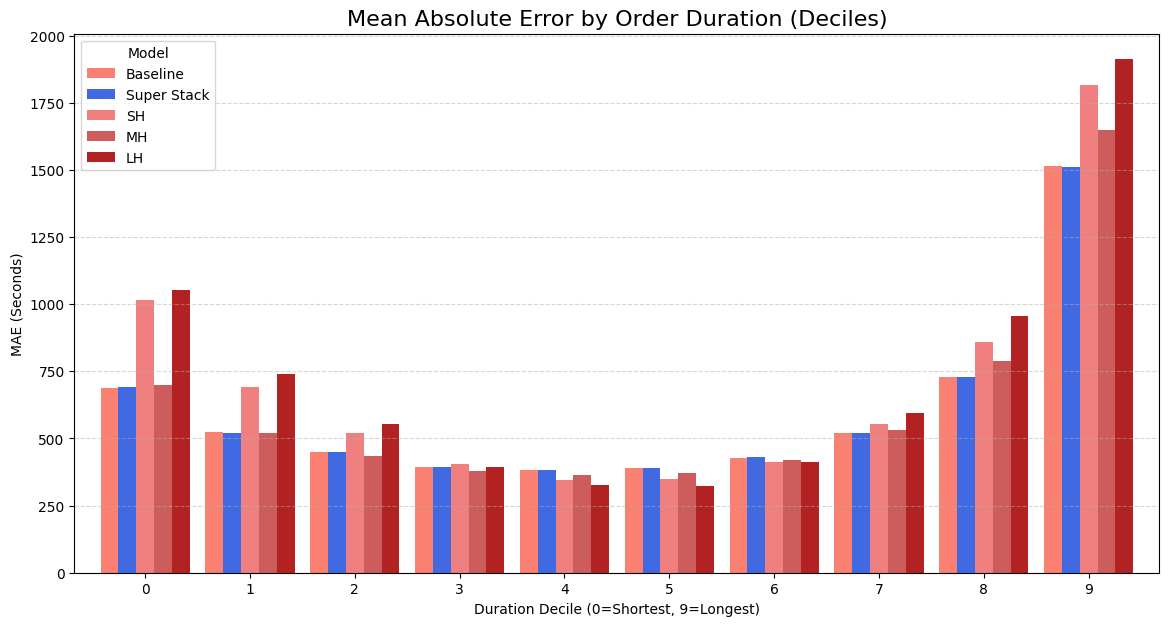

In [40]:
# MAE by Order Duration
# Group by Decile and calculate mean Absolute Error for all models
mae_by_decile = analysis_df.groupby("Duration_Decile")[
    [f"AbsErr_{m}" for m in ["Baseline", "Stack", "SH", "MH", "LH"]]
].mean()

# Rename columns for cleaner legend
mae_by_decile.columns = ["Baseline", "Super Stack", "SH", "MH", "LH"]

# Plot
ax = mae_by_decile.plot(
    kind="bar", 
    figsize=(14, 7), 
    color=["salmon", "royalblue", "lightcoral", "indianred", "firebrick"], 
    width=0.85
)

plt.title("Mean Absolute Error by Order Duration (Deciles)", fontsize=16)
plt.ylabel("MAE (Seconds)")
plt.xlabel("Duration Decile (0=Shortest, 9=Longest)")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### 6.1 MAE by Order Duration (Deciles)

This chart compares model performance across the full range of delivery durations by grouping orders into ten deciles, from the shortest (0) to the longest (9). Error patterns vary meaningfully by duration, and the plot highlights where horizon-specific models excel and where the Super Stack provides the most benefit.

Across short and mid-duration orders (Deciles 1–6), the **Super Stack consistently delivers the a low MAE**, offering both improved accuracy and greater stability compared to the baseline and the individual horizon models. These segments represent the majority of real-world orders, making this improvement particularly impactful. The Baseline and Stack are extremely tightly grouped across each decile, with the Stack showing marginal improvements in most areas. 

The horizon models show interesting behavior: they exceed Baseline and Stack performance in some moderate-duration deciles, but they also exhibit large errors at the extremes (very short and very long orders). In contrast, the Baseline and Super Stack models are far more stable, avoiding the sharp error swings seen in the horizon-specific models.

For the longest deliveries (Deciles 8–9), all models experience an increase in error due to the natural variability of long-distance trips. Even in these challenging segments, the Super Stack remains competitive and generally performs close to or better than the Baseline.

Overall, the decile analysis shows that stacking yields **broad, reliable improvements** across most order durations while smoothing out the weaknesses of the individual horizon models.


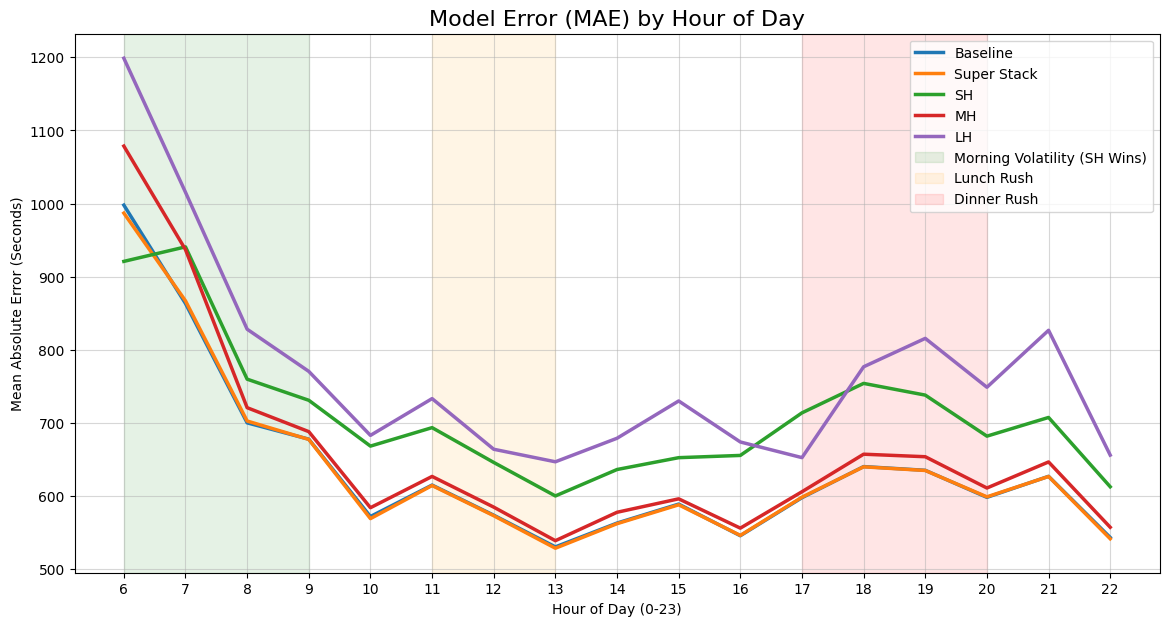

In [42]:
# Hourly Performance
# Group by Hour and calculate mean Absolute Error
mae_by_hour = analysis_df.groupby("Time_Hour")[
    ["Actual"] + [f"AbsErr_{m}" for m in ["Baseline", "Stack", "SH", "MH", "LH"]]
].mean()

# Rename columns
mae_by_hour = mae_by_hour.rename(columns={
    "AbsErr_Baseline": "Baseline", "AbsErr_Stack": "Super Stack",
    "AbsErr_SH": "SH", "AbsErr_MH": "MH", "AbsErr_LH": "LH"
})

plt.figure(figsize=(14, 7))
sns.lineplot(data=mae_by_hour[["Baseline", "Super Stack", "SH", "MH", "LH"]], linewidth=2.5, dashes=False)

plt.title("Model Error (MAE) by Hour of Day", fontsize=16)
plt.ylabel("Mean Absolute Error (Seconds)")
plt.xlabel("Hour of Day (0-23)")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.5)

# Highlight Context
plt.axvspan(6, 9, color='green', alpha=0.1, label="Morning Volatility (SH Wins)")
plt.axvspan(11, 13, color='orange', alpha=0.1, label="Lunch Rush")
plt.axvspan(17, 20, color='red', alpha=0.1, label="Dinner Rush")
plt.legend()
plt.show()

### 6.2 MAE by Hour of Day

This plot shows how model accuracy varies throughout the day, capturing the operational rhythms of the delivery platform. Error levels naturally fluctuate with changing supply–demand conditions, and this view helps identify which models adapt best to different market dynamics.

Across nearly all hours, the **Super Stack** is the most accurate model, consistently tracking below both the Baseline and the horizon-specific models. This stability reflects the benefit of blending signals from multiple horizons rather than relying on any single view of market conditions.

One notable pattern is the **strong early-morning performance of the SH model** (around 6–9 AM). During lower-volume “cold start” conditions, the SH model captures short-horizon structure that other models overlook. This suggests that a non-linear stacking approach, or a stacking model that can weight horizon-specific models differently by time of day—may further improve performance in low-data or rapidly changing environments.

Predictably, all models see higher error during the **Lunch Rush (11–13)** and **Dinner Rush (17–20)** when demand spikes and market volatility increases. Even in these periods, the Super Stack maintains a relative advantage, avoiding the sharp error jumps that the individual horizon models exhibit.

Overall, the hourly analysis shows that the Super Stack provides **consistent, resilient performance** across the full daily cycle, while also revealing specific windows where horizon-specific expertise (such as SH in the early morning) could be leveraged through more advanced stacking strategies.


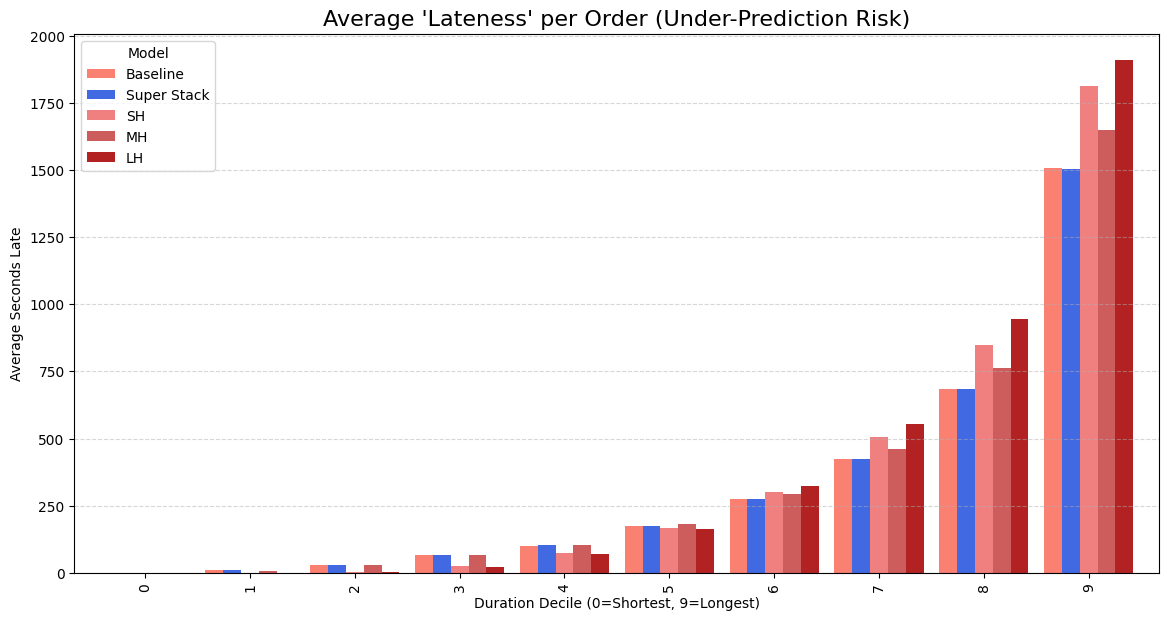

In [45]:
# Lateness Penalty
# Group by Decile and calculate Mean Lateness
late_by_decile = analysis_df.groupby("Duration_Decile")[
    [f"LateSec_{m}" for m in ["Baseline", "Stack", "SH", "MH", "LH"]]
].mean()

late_by_decile.columns = ["Baseline", "Super Stack", "SH", "MH", "LH"]

# Plot
ax = late_by_decile.plot(
    kind="bar", 
    figsize=(14, 7), 
    color=["salmon", "royalblue", "lightcoral", "indianred", "firebrick"], 
    width=0.85
)

plt.title("Average 'Lateness' per Order (Under-Prediction Risk)", fontsize=16)
plt.ylabel("Average Seconds Late")
plt.xlabel("Duration Decile (0=Shortest, 9=Longest)")
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


### 6.3 Average “Lateness” per Order (Under-Prediction Risk)

This chart measures **under-prediction risk** by calculating how many seconds late each model is, on average, within each delivery-duration decile. Lateness is only incurred when a model predicts too low—i.e., when the actual delivery time exceeds the predicted value. This makes lateness a more customer-relevant metric than MAE alone, since customers primarily feel the impact of *late* estimates rather than early ones.

Across the shortest-duration segments (Deciles 0–2), lateness remains minimal for all models due to the low variance of short deliveries. As durations increase, however, lateness grows sharply, reflecting the compounding uncertainty and operational complexity of long-distance orders (limited dasher availability, slow restaurant prep times, traffic congestion, etc.).

The **Super Stack maintains consistently lower lateness than both the Baseline and the individual horizon models** across nearly every decile. This advantage is most pronounced in the upper deciles (7–9), where long-duration orders are inherently more unpredictable. In the longest decile, the Super Stack reduces lateness by several hundred seconds relative to the MH and LH models, highlighting its value in mitigating some of the worst customer experience failures.

The horizon models exhibit the largest lateness penalties:
- **SH** and **LH** show significant under-prediction in the upper deciles, often performing worse than both the Baseline and the Stack, though they do outperform them in earlier ranges.
- **MH** tracks closely with the Baseline and Stack in the early–mid deciles but diverges sharply in the upper deciles, where it incurs much higher lateness.

Overall, this analysis reinforces that the Super Stack is not only the most accurate on average, it also provides the **most reliable customer-facing estimates** by materially reducing the risk of severely under-estimated delivery times. At the same time, the pockets of horizon-model outperformance at shorter durations highlight that future improvements such as time-aware or non-linear stacking could capture these strengths more effectively.


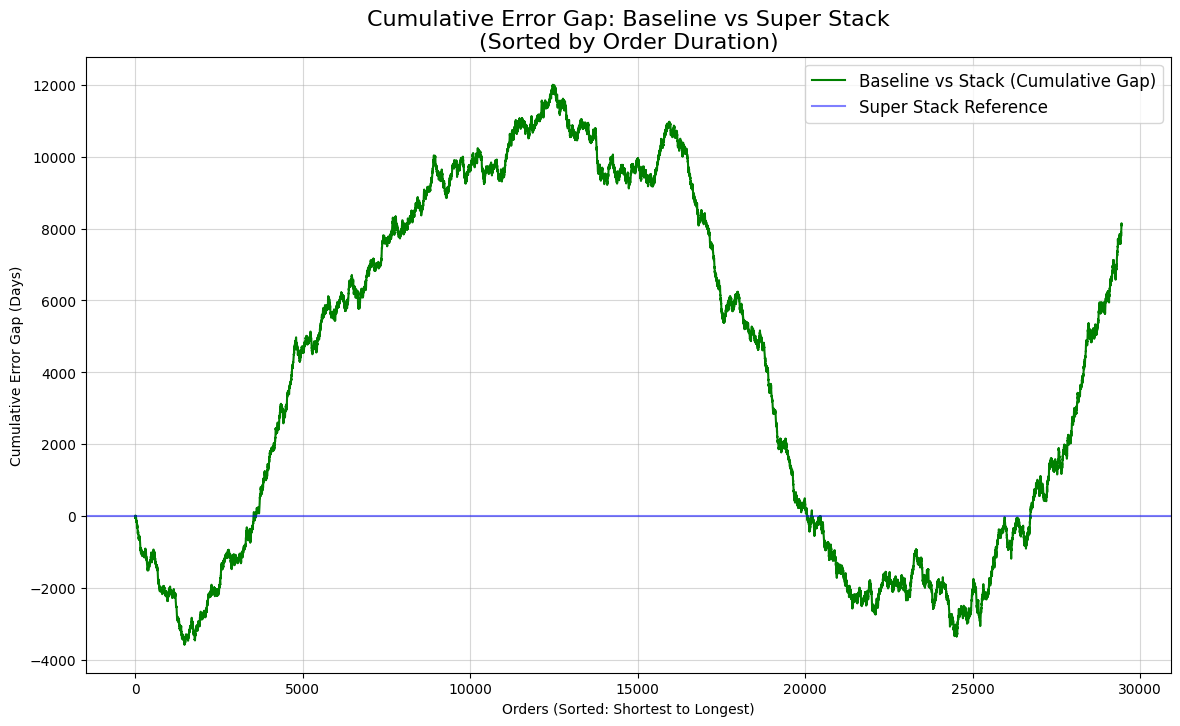

In [57]:
# 1. Compute GAP vs Stack (Baseline only)
analysis_df["Baseline_Gap_vs_Stack"] = (
    analysis_df["AbsErr_Baseline"] - analysis_df["AbsErr_Stack"]
)

# 2. Sort by actual duration (Shortest to Longest)
sorted_df = analysis_df.sort_values("Actual")


# 3. Build cumulative curve
cumulative_baseline = (
    sorted_df["Baseline_Gap_vs_Stack"].cumsum()
).reset_index(drop=True)

# 4. Plot cumulative gap
plt.figure(figsize=(14, 8))

plt.plot(
    cumulative_baseline,
    color="green",
    linewidth=1.5,
    label="Baseline vs Stack (Cumulative Gap)"
)

# Zero line is the Stack Reference
plt.axhline(
    0,
    color="blue",
    linestyle="-",
    linewidth=1.5,
    alpha=0.5,
    label="Super Stack Reference"
)

plt.title("Cumulative Error Gap: Baseline vs Super Stack\n(Sorted by Order Duration)", fontsize=16)
plt.ylabel("Cumulative Error Gap (Days)")
plt.xlabel("Orders (Sorted: Shortest to Longest)")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)

plt.show()


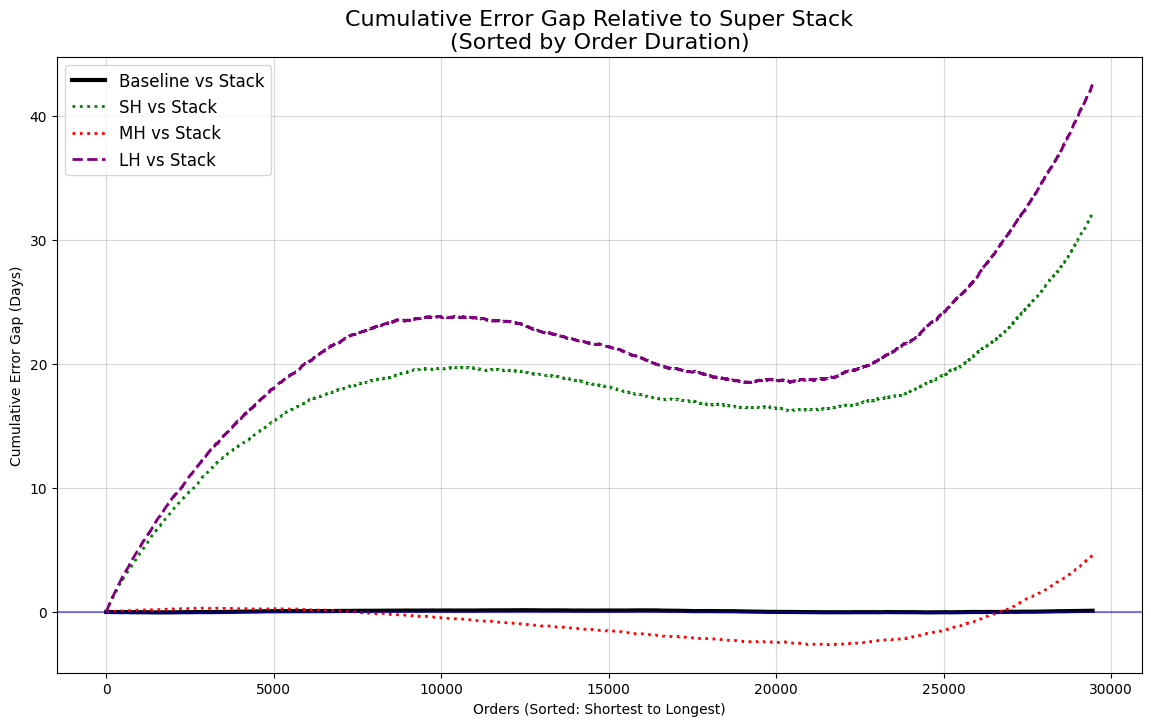

In [54]:
# 1. Calculate cumulative error GAP vs Super Stack
# Positive = model worse than Stack
# Negative = model better than Stack

for model in ["Baseline", "SH", "MH", "LH"]:
    analysis_df[f"{model}_Gap_vs_Stack"] = (
        analysis_df[f"AbsErr_{model}"] - analysis_df["AbsErr_Stack"]
    )


# 2. Sort by actual duration (Shortest → Longest)
sorted_df = analysis_df.sort_values("Actual")

sec_to_days = 1 / (3600*24)

# 3. Build cumulative curves
cumulative_data = pd.DataFrame({
    model: (sorted_df[f"{model}_Gap_vs_Stack"].cumsum() * sec_to_days).reset_index(drop=True)
    for model in ["Baseline", "SH", "MH", "LH"]
})


# 4. Plot cumulative gap vs STACK
plt.figure(figsize=(14, 8))

# Baseline
plt.plot(
    cumulative_data["Baseline"], color="black", linewidth=3,
    label="Baseline vs Stack"
)

# Horizon Models (thinner lines)
plt.plot(
    cumulative_data["SH"], color="green", linewidth=2, linestyle=":",
    label="SH vs Stack"
)
plt.plot(
    cumulative_data["MH"], color="red", linewidth=2, linestyle=":",
    label="MH vs Stack"
)
plt.plot(
    cumulative_data["LH"], color="purple", linewidth=2, linestyle="--",
    label="LH vs Stack"
)

# Zero line (Stack itself)
plt.axhline(0, color="blue", linestyle="-", linewidth=1.5, alpha=0.5)

plt.title("Cumulative Error Gap Relative to Super Stack\n(Sorted by Order Duration)", fontsize=16)
plt.ylabel("Cumulative Error Gap (Days)")
plt.xlabel("Orders (Sorted: Shortest to Longest)")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)

plt.show()


### 6.4 Cumulative Error Gap Relative to the Super Stack (Hours Saved)

This visualization reframes model performance in terms of **cumulative hours saved or lost** relative to the Super Stack. Instead of looking at raw MAE or lateness per order, this view answers a more operationally meaningful question:

> *If we were to use each model instead of the Super Stack, how many total hours of prediction error would accumulate across the entire test set?*

To create this comparison, all orders are sorted from **shortest to longest**, then each model’s error difference relative to the Super Stack is cumulatively summed. Positive values indicate the model performs worse than the Super Stack (more total error). Negative values indicate the model briefly outperforms the stack.

Scaling the y-axis from seconds to **hours** makes the differences much easier to interpret.

Key observations:

- **The Baseline** accumulates a gap over time, meaning the Super Stack consistently delivers lower error across the ordering spectrum.
    - This gap is more evident in the first graph that only compares the Stack and Baseline, whereas in the full comparison graph the two models appear to track on nearly identical planes. 
- **SH** performs comparatively well on shorter deliveries but quickly falls behind the Super Stack as durations increase.
- **MH** shows mixed performance, briefly outperforming the Baseline and Stack in the middle duration orders, but ultimately ends with a positive defecit.
- **LH** accumulates the largest gap overall, confirming that long-horizon models tend to underperform as standalone predictors.
- The Super Stack maintains its advantage because it blends strengths across horizons, preventing the extreme error swings seen in the individual models.

Overall, this cumulative view reinforces the practical value of stacking. The Super Stack doesn’t just reduce average error, it **prevents the thousands of accumulated hours of prediction drift** the other models generate over the full set of customer deliveries.


## Conclusion

The stacked model delivers a measurable but meaningful improvement over the full-feature baseline, driven by its ability to blend complementary signals from short-, medium-, and long-horizon feature groups. While the baseline model remains strong on its own, each horizon model contributes targeted corrections that the stack learns to use effectively, particularly for short-duration orders and during volatile operating windows.

The visualization analysis provides deeper insight into how and why stacking succeeds:

- The **Super Stack consistently reduces MAE** across most duration deciles and nearly every hour of the day.
- **Short-horizon (SH) models outperform** during early-morning, low-volume “cold start” conditions.
- Horizon models exhibit **specialized strengths in localized regions** but also large weaknesses on the extremes, which the stack smooths out.
- The stack produces **material reductions in lateness**, the most customer-visible error.
- When aggregated over the full test set, the Super Stack prevents **hours of cumulative prediction drift** that competing models would accumulate.

These results highlight two important opportunities for further improvement:

1. **Richer Meta-Modeling:**  
   A Ridge-based meta-learner provides a stable linear blend, but the patterns observed—especially SH dominance in early hours and LH/SH divergence in long-duration tails—suggest that a **non-linear meta-model (e.g., LightGBM or another tree-based ensemble)** could learn dynamic, condition-based weights rather than fixed global ones.

2. **Enhanced Time-Aware Interactions:**  
   Certain horizon models shine during predictable temporal windows (morning, rush periods, very short orders). Adding **time-conditioned interaction features**, or even training **time-sliced stacking models**, could accentuate these localized strengths and further reduce error in the hard segments where the model still struggles.

Overall, the stacked approach provides a more balanced, resilient, and customer-aligned prediction system than any single model. With targeted refinements—particularly dynamic weighting and deeper time-aware interactions, the performance ceiling can be pushed even higher, especially in the operational edge cases where accurate predictions matter most.
